# 미세먼지 예측
## 가설 : 이산화질소(NO2)가 미세먼지 증가에 가장 큰 영향을 미칠까?

In [1]:
# 데이터 구성 : Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# 데이터 scaling
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# 데이터 분할 : train, test
from sklearn.model_selection import train_test_split
# scaling 클래스
from sklearn.preprocessing import scale
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 모델 성능 평가
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import omni_normtest
# 회귀분석
from statsmodels.formula.api import ols
# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 formula(y ~ X1+X2+...)
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## 1. 데이터 정제

In [2]:
# 데이터 불러오기
df_raw=pd.read_csv("C:\\Users\\Administrator\\Jupyter\\BigData_Analysis\\data\\AIR_POLLUTION.csv", encoding="CP949")
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [3]:
# 결측치 확인 결과 결측치 존재
df_raw.isnull().sum()

MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

In [4]:
# 결측치를 fillna의 method의 속성을 통해 ffill을 이용하여 결측치가 있다면 바로 위의 데이터 값으로 대체하였다.
# ffill의 단점은 가장 상위의 값이 비어있다면 그 부분을 채울 수 없다는 것인데, 직접 1행의 데이터를 확인하여 
# 이상이 없는 것을 확인하고 진행하였다.
# 날짜의 흐름에 따라 데이터가 생성되므로 하루 간격의 데이터는 차이가 크지 않을 것이라고 판단하였다.
# 그러나 CO는 2019년 7월 26일부터 2019년 9월 17일까지 55일동안 결측치가 이어서 존재하여 결측치에 대한 예측의 오차가 클 것이라
# 판단되어 일단은 채워놓고 가급적이면 다른 설명변수를 이용해야 할 것 같다.
df_raw.fillna(method='ffill', inplace=True)

In [5]:
# 결측치 제거 후 display
df_raw.isnull().sum()

MeasDate     0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
dtype: int64

In [6]:
# 데이터 요약 확인, 변수간 데이터 크기의 편차가 크므로 scale 필요성을 느꼈다.
# scale 후 데이터 이상치를 확인해야겠다.
df_raw.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,33.467213,0.023596,0.026803,0.484973,0.003033,13.863798,0.381639,2.225301,209.450820,60.295082,1005.848907,0.022951,5.064016
std,15.939707,0.011880,0.010259,0.160541,0.000632,9.830280,1.122127,0.723171,70.735018,14.534983,8.126823,0.222361,2.986119
min,5.000000,0.002000,0.008000,0.300000,0.002000,-7.950000,0.000000,0.940000,50.000000,17.900000,983.800000,0.000000,0.000000
25%,22.000000,0.014250,0.019000,0.400000,0.003000,5.492500,0.000000,1.722500,160.250000,49.650000,999.400000,0.000000,2.510000
50%,31.000000,0.023000,0.025000,0.500000,0.003000,14.000000,0.000000,2.095000,221.000000,61.050000,1006.450000,0.000000,5.310000
75%,42.750000,0.032000,0.033750,0.600000,0.003000,23.070000,0.115000,2.620000,266.000000,69.950000,1011.575000,0.000000,7.570000
max,101.000000,0.062000,0.059000,1.000000,0.005000,31.720000,11.800000,5.880000,351.000000,95.000000,1025.500000,3.200000,10.000000


In [7]:
# MeasDate는 변수역할에서 제외이므로 삭제한 후 scale을 진행하였다.
df_raw=df_raw.drop(["MeasDate"], axis=1)

In [8]:
# 평균=0, 표준편차=1 을 기준으로 scale을 변환해주었다. 
df_scale_std=scale(df_raw)
df_scale_std=pd.DataFrame(df_scale_std, columns=df_raw.columns)
df_scale_std.head()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,-0.280641,2.562792,-0.566476,0.093732,-0.051982,1.035588,-0.340569,0.103436,0.559883,0.200131,-1.324456,-0.103356,0.213272
1,-0.469107,2.478501,-0.664089,0.093732,-0.051982,1.062073,-0.340569,0.048048,0.786389,0.200131,-0.893194,-0.103356,-0.413817
2,-0.217818,1.551309,-0.371250,-0.530013,-0.051982,1.050868,-0.340569,-0.602757,0.998738,0.344807,-0.930159,-0.103356,0.411123
3,-0.343463,0.876987,-0.078411,-0.530013,-0.051982,1.170051,-0.340569,-0.256584,0.758076,-0.116780,-1.139630,-0.103356,-0.846407
4,-0.280641,1.804179,0.800107,0.093732,-0.051982,1.368689,-0.340569,-1.073552,-0.487707,-1.019288,-1.521605,-0.103356,-0.383636


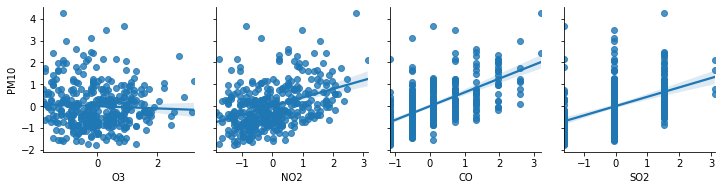

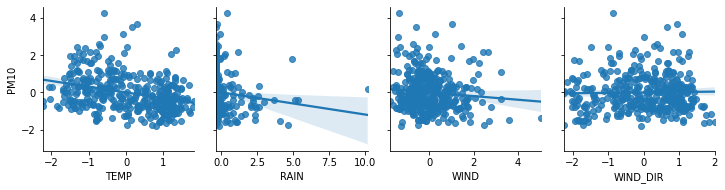

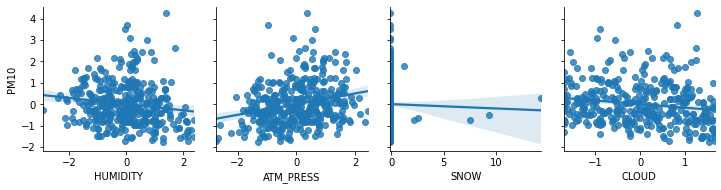

In [9]:
sns.pairplot(df_scale_std,y_vars="PM10",x_vars=["O3","NO2","CO","SO2"], kind="reg",diag_kind=None)
sns.pairplot(df_scale_std,y_vars="PM10",x_vars=["TEMP","RAIN","WIND","WIND_DIR"], kind="reg",diag_kind=None)
sns.pairplot(df_scale_std,y_vars="PM10",x_vars=["HUMIDITY","ATM_PRESS","SNOW","CLOUD"], kind="reg",diag_kind=None)

In [10]:
# 이상치 제거, RAIN이 10을 초과한 변수를 제거하였다. 비가 엄청 많이 왔는데 미세먼지의 농도가 줄어들지 않아서 가설에 위반되기 때문이다.
df_scale_std=df_scale_std[df_scale_std["RAIN"]<10]
df_raw.reset_index(drop=True, inplace=True)

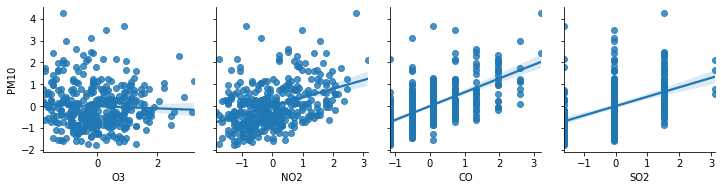

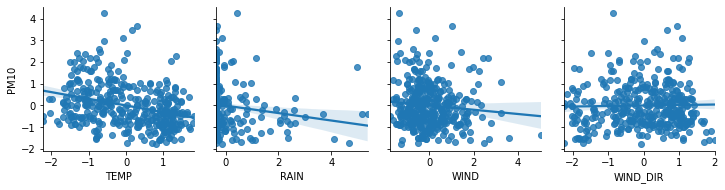

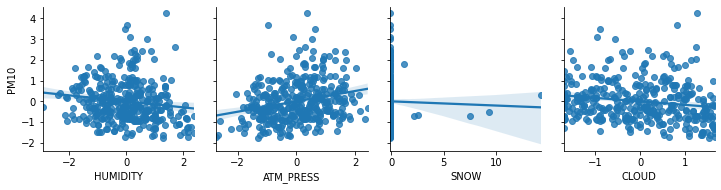

In [11]:
# 이상치 제거 후 그래프
sns.pairplot(df_scale_std,y_vars="PM10",x_vars=["O3","NO2","CO","SO2"], kind="reg",diag_kind=None)
sns.pairplot(df_scale_std,y_vars="PM10",x_vars=["TEMP","RAIN","WIND","WIND_DIR"], kind="reg",diag_kind=None)
sns.pairplot(df_scale_std,y_vars="PM10",x_vars=["HUMIDITY","ATM_PRESS","SNOW","CLOUD"], kind="reg",diag_kind=None)

In [12]:
# 상관관계 분석
df_scale_std.corr().round(3)

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
PM10,1.000,-0.052,0.395,0.630,0.429,-0.308,-0.145,-0.098,0.023,-0.145,0.250,-0.020,-0.169
O3,-0.052,1.000,-0.590,-0.496,-0.231,0.516,-0.088,0.164,0.265,-0.039,-0.536,0.004,-0.117
NO2,0.395,-0.590,1.000,0.751,0.560,-0.237,-0.022,-0.538,-0.404,-0.067,0.424,-0.121,0.011
CO,0.630,-0.496,0.751,1.000,0.586,-0.547,-0.101,-0.266,-0.269,-0.099,0.521,-0.028,-0.087
SO2,0.429,-0.231,0.560,0.586,1.000,-0.273,-0.203,-0.253,-0.087,-0.302,0.337,-0.103,-0.196
TEMP,-0.308,0.516,-0.237,-0.547,-0.273,1.000,0.106,-0.215,-0.052,0.404,-0.793,-0.185,0.344
RAIN,-0.145,-0.088,-0.022,-0.101,-0.203,0.106,1.000,0.157,-0.162,0.475,-0.266,0.026,0.395
WIND,-0.098,0.164,-0.538,-0.266,-0.253,-0.215,0.157,1.000,0.237,-0.080,-0.056,0.145,0.020
WIND_DIR,0.023,0.265,-0.404,-0.269,-0.087,-0.052,-0.162,0.237,1.000,-0.096,0.064,0.108,-0.292
HUMIDITY,-0.145,-0.039,-0.067,-0.099,-0.302,0.404,0.475,-0.080,-0.096,1.000,-0.512,0.021,0.630


In [13]:
reg_model=smf.ols(formula="PM10 ~ O3+NO2+CO+SO2+TEMP+RAIN+WIND+WIND_DIR+HUMIDITY+ATM_PRESS+SNOW+CLOUD", data=df_scale_std)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     32.38
Date:                Mon, 24 May 2021   Prob (F-statistic):           8.84e-50
Time:                        23:04:25   Log-Likelihood:                -382.66
No. Observations:                 365   AIC:                             791.3
Df Residuals:                     352   BIC:                             842.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0008      0.037      0.021      0.9

In [14]:
df_raw_x=df_scale_std.drop("PM10", axis=1)
df_raw_x_const=add_constant(df_raw_x)
df_vif=pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)
# 다중공산성을 확인했을 때 10 넘는 게 없기 때문에 p-value값이 큰 것을 제외하기로 결정

,variable,VIF
0,const,1.002
11,SNOW,1.120
8,WIND_DIR,1.503
6,RAIN,1.552
4,SO2,1.922
7,WIND,1.947
12,CLOUD,2.088
9,HUMIDITY,2.814
1,O3,2.922
10,ATM_PRESS,4.671


In [15]:
# p-value가 높고, std err(표준오차 값이 큰) SO2 제외
reg_model=smf.ols(formula="PM10 ~ O3+NO2+CO+TEMP+RAIN+WIND+WIND_DIR+HUMIDITY+ATM_PRESS+SNOW+CLOUD", data=df_scale_std)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     35.42
Date:                Mon, 24 May 2021   Prob (F-statistic):           1.46e-50
Time:                        23:04:25   Log-Likelihood:                -382.68
No. Observations:                 365   AIC:                             789.4
Df Residuals:                     353   BIC:                             836.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0008      0.037      0.021      0.9

In [16]:
# p-value가 높은 CLOUD 제외
reg_model=smf.ols(formula="PM10 ~ O3+NO2+CO+TEMP+RAIN+WIND+WIND_DIR+HUMIDITY+ATM_PRESS+SNOW", data=df_scale_std)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     39.06
Date:                Mon, 24 May 2021   Prob (F-statistic):           2.31e-51
Time:                        23:04:25   Log-Likelihood:                -382.69
No. Observations:                 365   AIC:                             787.4
Df Residuals:                     354   BIC:                             830.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0008      0.037      0.021      0.9

In [17]:
# p-value가 높은 RAIN 제외
reg_model=smf.ols(formula="PM10 ~ O3+NO2+CO+TEMP+WIND+WIND_DIR+HUMIDITY+ATM_PRESS+SNOW", data=df_scale_std)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     43.44
Date:                Mon, 24 May 2021   Prob (F-statistic):           4.10e-52
Time:                        23:04:26   Log-Likelihood:                -382.89
No. Observations:                 365   AIC:                             785.8
Df Residuals:                     355   BIC:                             824.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0017      0.037      0.045      0.9

In [18]:
# p-value가 높은 SNOW 제외
reg_model=smf.ols(formula="PM10 ~ O3+NO2+CO+TEMP+WIND+WIND_DIR+HUMIDITY+ATM_PRESS", data=df_scale_std)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     48.91
Date:                Mon, 24 May 2021   Prob (F-statistic):           6.73e-53
Time:                        23:04:26   Log-Likelihood:                -383.07
No. Observations:                 365   AIC:                             784.1
Df Residuals:                     356   BIC:                             819.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0017      0.037      0.045      0.9

In [19]:
# 후진제거법을 이용하여 변수를 4개부터 7개까지 선택을 바꿔보았지만 설명력이 모두 감소하였으므로 생략한다.
# 후진제거법을 이용한 변수 선택(6개까지)
df_raw_y=df_scale_std["PM10"]
df_raw_x=df_scale_std.drop(["PM10", "RAIN", "CLOUD", "SNOW"], axis=1)
model=LinearRegression()
rfe=RFE(estimator=model, n_features_to_select=6).fit(df_raw_x, df_raw_y)
selected_cols=df_raw_x.columns[rfe.support_]
removed_cols=df_raw_x.columns[~rfe.support_]
print("Selected Variables:{}".format(selected_cols))
print("Removed Variables:{}".format(removed_cols))

Selected Variables:Index(['O3', 'NO2', 'CO', 'TEMP', 'WIND_DIR', 'ATM_PRESS'], dtype='object')
Removed Variables:Index(['SO2', 'WIND', 'HUMIDITY'], dtype='object')


In [20]:
rfe_reg_model=smf.ols(formula="PM10 ~ O3+NO2+CO+TEMP+WIND_DIR+ATM_PRESS", data=df_scale_std)
rfe_reg_result=rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     64.43
Date:                Mon, 24 May 2021   Prob (F-statistic):           5.26e-54
Time:                        23:04:26   Log-Likelihood:                -384.76
No. Observations:                 365   AIC:                             783.5
Df Residuals:                     358   BIC:                             810.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0015      0.037      0.040      0.9

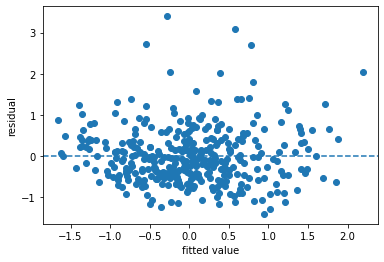

In [21]:
# 잔차 분석
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel('residual')
plt.axhline(y=0, linestyle='--')

NormaltestResult(statistic=92.26029357820737, pvalue=9.245529743804823e-21)

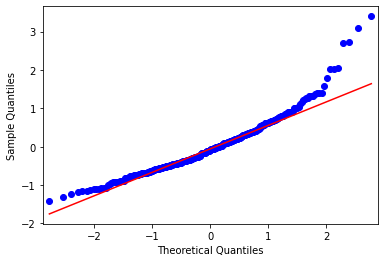

In [22]:
qqplot(reg_result.resid, line='q')
omni_normtest(reg_result.resid, axis=0)

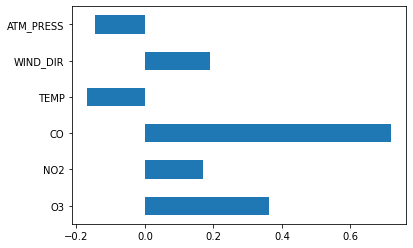

In [23]:
df_reg_coef=pd.DataFrame({"Coef":rfe_reg_result.params.values[1:]}, index=selected_cols)
df_reg_coef.plot.barh(y="Coef", legend=False)

In [24]:
# CO(일산화탄소 농도), 오존 농도(O3) 순으로 변수가 중요한 것을 알았다.
# 변수 모두 p-value가 0.05보다 작기 때문에 회귀모델로서 유의하다고 볼 수 있다.

In [25]:
# 의사결정나무

In [26]:
df_raw_y=df_raw["PM10"]
df_raw_x=df_raw.drop("PM10", axis=1, inplace=False)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)

In [28]:
estimator=DecisionTreeRegressor(random_state=1234)
para_split=[n_split*2 for n_split in range(2, 20)]
para_depth=[depth for depth in range(1, 11)]
para_leaf=[n_leaf*1 for n_leaf in range(1, 20)]
param_grid={"max_depth":para_depth, "min_samples_split": para_split, "min_samples_leaf": para_leaf}
grid_dt=GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(x_train, y_train)

print("best estimator model:\n{}".format(grid_dt.best_estimator_))
print("\nbest parameter :\n{}".format(grid_dt.best_params_))
print("\nbest score :\n{}".format(grid_dt.best_score_.round(3)))

best estimator model:
DecisionTreeRegressor(max_depth=5, min_samples_leaf=13, min_samples_split=4,
                      random_state=1234)

best parameter :
{'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 4}

best score :
0.383


In [29]:
tree_final=DecisionTreeRegressor(max_depth=5, min_samples_leaf=13, min_samples_split=4, random_state=1234)
tree_final.fit(x_train, y_train)
v_feature_name=x_train.columns
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=tree_final.feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.590
0,O3,0.152
11,CLOUD,0.135
7,WIND_DIR,0.061
6,WIND,0.043
4,TEMP,0.019
1,NO2,0.000
3,SO2,0.000
5,RAIN,0.000
8,HUMIDITY,0.000


Text(0, 0.5, '변수')

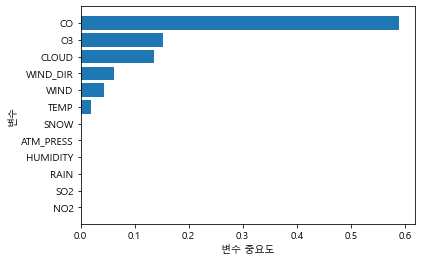

In [30]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
matplotlib.rc("font", family="Malgun Gothic")
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

# 의사결정나무 결과 

In [31]:
# 랜덤 포레스트

In [32]:
estimator=RandomForestRegressor(random_state=1234)
para_split=[n_split*2 for n_split in range(2, 20)]
para_depth=[depth for depth in range(1, 11)]
para_split=[n_split*2 for n_split in range(2, 21)]
para_n_tree=[n_tree * 10 for n_tree in range(1, 11)]

param_grid={"max_depth":para_depth, "min_samples_split": para_split, "min_samples_leaf": para_leaf}
grid_dt=GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(x_train, y_train)

print("best estimator model:\n{}".format(grid_dt.best_estimator_))
print("\nbest parameter :\n{}".format(grid_dt.best_params_))
print("\nbest score :\n{}".format(grid_dt.best_score_.round(3)))

best estimator model:
RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=4,
                      random_state=1234)

best parameter :
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 4}

best score :
0.491


In [33]:
rf_final=RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=4, random_state=1234)
rf_final.fit(x_train, y_train)
v_feature_name=x_train.columns
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=rf_final.feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.468
0,O3,0.155
11,CLOUD,0.079
7,WIND_DIR,0.069
4,TEMP,0.051
8,HUMIDITY,0.048
1,NO2,0.037
9,ATM_PRESS,0.032
6,WIND,0.028
3,SO2,0.021


Text(0, 0.5, '변수')

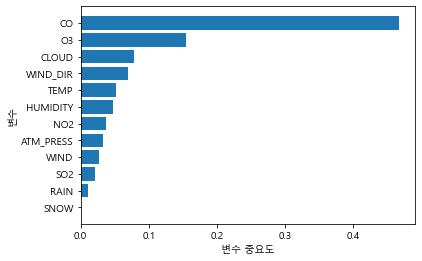

In [34]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
matplotlib.rc("font", family="Malgun Gothic")
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

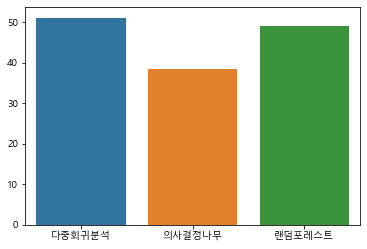

In [35]:
# 설명력 비교
matplotlib.rc('font', family='Malgun Gothic')
df_explain=pd.DataFrame({'다중회귀분석':[51.1],
                       '의사결정나무':[38.3],
                       '랜덤포레스트':[49.1]})
sns.barplot(data=df_explain)

In [36]:
# 중요도 비교
matplotlib.rc('font', family='Malgun Gothic')
df_importance1=df_importance.sort_values("Importance", ascending=True, inplace=True)
df_importance1
# sns.barplot(data=df_explain)

결론 : 미세먼지 유발에 가장 큰 영향을 미치는 것은 CO2이다. 다중회귀분석 모델이 이 데이터 분석에 있어 가장 적합한 모델이다.